<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2019/sem_6/student_teacher_dist.png" height="300" width="700"> 
</center>

# <center> R для тервера и матстата. <br>  <br> Критерии согласия </center>


---------------

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2020). Автор ноутбука - [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://github.com/FUlyankin/r_probability) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

-----------

Пришло время обсудить критерии согласия.  __Критерий согласия -__ критерий о виде неизвестного закона распределения. Критерии согласия бывают разными. Все они строятся ровно на той же мысли, что и параметрические критерии. Нужно считать расстояния. И в данной ситуации это расстояния между распределениями. 

In [7]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов
library("dplyr")    # Куда же без пакета под таблички :) 
library("rio")

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

# 1. Эмпирическая функция распределения 

Эмпирическая функция распределения это:

$$
F_n(y) = \frac{1}{n} \sum_{i=1}^n I_{x_i \le y}
$$

Обычно её используют как оценку теоретической функции распределения. __Вопрос:__ какими свойствами обладает такая оценка? Можно ли для неё построить доверительный интервал? 

### Упражнение 

Помните данные по угольным шахтам? Давайте построим по ним эмпирическую функцию распределения. И для каждой точке на ней построи доверительный интервал. 

In [8]:
df = import('coals.txt')
head(df)

V1,year,count
1,1851,4
2,1852,5
3,1853,4
4,1854,1
5,1855,0
6,1856,4


In [ ]:
# код :3

-----

# 2. Расстояние между распределениями

Для начала построим красивую картинку и попытаемся понять как можно измерить расстояние между двумя разными распределениями. 

In [9]:
n_obs = 100
sample1 <- rnorm(n_obs, mean=10, sd=5)
sample2 <- rnorm(n_obs, mean=1, sd=5)

# создали эмпирические функции распределения на основе данных
cdf1 <- ecdf(sample1) 
cdf2 <- ecdf(sample2) 

df <- data.frame(sample1 = sample1, sample2 = sample2)

# находим супремум (ниже поймём зачем)
minMax <- seq(min(sample1, sample2), max(sample1, sample2), length.out=length(sample1)) 
x0 <- minMax[which(abs(cdf1(minMax) - cdf2(minMax)) == max(abs(cdf1(minMax) - cdf2(minMax))))] 
y0 <- cdf1(x0) 
y1 <- cdf2(x0) 

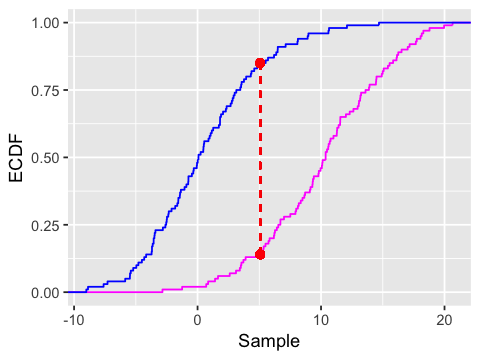

In [10]:
ggplot(df)+
    stat_ecdf(aes(x=sample1), col='magenta') + 
    stat_ecdf(aes(x=sample2), col='blue') +
    geom_segment(aes(x = x0[1], y = y0[1], xend = x0[1], yend = y1[1]),
        linetype = "dashed", color = "red") + 

    geom_point(aes(x = x0[1] , y= y0[1]), color="red", size=2) +
    geom_point(aes(x = x0[1] , y= y1[1]), color="red", size=2) +
    xlab("Sample") +
    ylab("ECDF")

### Теорема (ЗБЧ)

Как это ни странно $\hat F_n(x) \overset{\text{p}}{\to} F(x)$ для любой точки $x$ (поточечная сходимость).

### Теорема (Гливенко-Кантелли)

Пусть $X_1, \ldots, X_n \sim iid F$, где $F$ - какой-то закон распределения. Тогда для эмпирической функции распределения $\hat F_n$, построенной на основе этой выборки справедливо, что 

$$
\sup_{x \in \mathbb{R}} \mid \hat F_n(x) - F(x) \mid \overset{\text{п.н.}}{\to} 0
$$

Эта теорема сильнее, чем ЗБЧ и говорит о равномерной сходимости по всем $x$, а не о сходимости в какой-то конкретной точке. 

### Теорема (Колмогорова)

Пусть $X_1, \ldots, X_n \sim iid F$, где $F$ - какой-то __непрерывный__ закон распределения. Тогда для эмпирической функции распределения $\hat F_n$, построенной на основе этой выборки справедливо, что 

$$
\sqrt{n} \cdot \sup_{x \in \mathbb{R}} \mid \hat F_n(x) - F(x) \mid \overset{d}{\to} D,
$$

где функция распределения случайной величины $D$ выглядит как

$$
F_D(x) = 1 + 2 \cdot \sum_{i=1}^{+\infty} (-1)^k \cdot e^{-2k^2 x^2}.
$$

# 3. Критерий Колмогорова

Теорема Колмогорова - наш новый союзник! Она подсказывает нам как именно будет распределён супремум между эмпирической функцией распределения и теоретической функцией распределения. Нам остаётся только найти по выборке оценку для этого супремума и посмотреть попал ли он в критическую область. 

__Гипотеза:__ 

$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

__Статистика:__ 

$$
D_n (x_1, \ldots x_n) = \sup_{x \in \mathbb{R}} \mid \hat F_n(x) - F(x) \mid =  \max_{1 \le i \le n} \left(\frac{i}{n} - F(x_{(i)});  F(x_{(i)}) - \frac{i - 1}{n} \right)  
$$

При справедливости нулевой гипотезы распределение статистики $D_n$ одинаково для любого исходного непрерывного распределения.

In [5]:
x <- rnorm(10) # выборка 
x <- sort(x)   # отсортируем её 
x

[1] -1.6666652 -1.3640702 -0.9225978 -0.8885293 -0.7442328 -0.3387812
 [7] -0.2832396  0.5990486  0.7224623  1.4524369

In [6]:
# значения настоящей функции распределения в соотвествующих точках
pnorm(sort(x))

[1] 0.04779049 0.08627273 0.17810841 0.18712804 0.22836781 0.36738728
 [7] 0.38849659 0.72542975 0.76499485 0.92680992

In [7]:
D = 0 # для наблюдаемого значения статистики

# идём по всем наблюдениям по очереди
for(i in 1:10){
    # оценили эмпирическую функцию в текущей точке и вычли теоретическую 
    d1 = i/10 - pnorm(x[i])
    
    # наоборот, если знак отрицательный, -1, чтобы учесть что P(X <= x)
    d2 = pnorm(x[i]) - (i - 1)/10
    
    # выбрали максимум
    if(max(d1, d2) > D){
        D = max(d1, d2)
    }
}

D

[1] 0.3115034

Сверимся с пакетом из R! 

In [8]:
ks.test(x, "pnorm", mean = 0, sd = 1)


	One-sample Kolmogorov-Smirnov test

data:  x
D = 0.3115, p-value = 0.2327
alternative hypothesis: two-sided


__Другой пример.__ Сгенерируем выборку из равномерного распределения и протестируем её на нормальность.

In [10]:
x <- runif(1000)
ks.test(x, "pnorm", mean = mean(x), sd = sd(x))


	One-sample Kolmogorov-Smirnov test

data:  x
D = 0.075062, p-value = 2.553e-05
alternative hypothesis: two-sided


$p$-value очень низкое. Гипотеза о нормальности отвергается. По аналогии можно протестировать гипотезу для любого распределения. Вот пример с экспоненциальным распределением: 

In [11]:
x <- rexp(1000, rate = 2)
ks.test(x, "pexp", rate = 2)


	One-sample Kolmogorov-Smirnov test

data:  x
D = 0.026691, p-value = 0.4744
alternative hypothesis: two-sided


__Ещё одно полезное свойство критерия:__ можно проверять гипотезу об однородности выборок, то есть пытаться понять из одного ли распределения они к нам пришли. Колмогоров доказал, что для этого случая распределение Колмогорова тоже подходит. В R это реализуется следующим образом: 

In [13]:
x <- rexp(100, rate = 2)
y <- rexp(100, rate = 2)
ks.test(x, y)


	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.08, p-value = 0.9062
alternative hypothesis: two-sided


In [14]:
x <- rexp(100, rate = 2)
y <- rnorm(100)
ks.test(x, y)


	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.56, p-value = 4.807e-14
alternative hypothesis: two-sided


> __Важно:__  Критерий работает только для непрерывных распределений! Для дискретных ситуаций обычно используют критерий Пирсона. 

# 4. Критерий Пирсона 

Расстояния между распределениями можно считать очень по-разному. Выше мы делали это через супремум. Критерий Пирсона предлагает делать это с помощью сверки эмпирических частот и теоретических. 

__Гипотеза:__ 

$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$


__Статистика:__ 

$$
\sum_{j=1}^k \frac{(v_j - n \cdot p_j(\hat \theta))^2}{n \cdot p_j(\hat \theta)} \sim \chi^2_{s - k - 1},
$$

где $\hat \theta$ - любая состоятельная оценка параметра, $v_j$ - частота, с которой значение $j$ встречалось в выборке, $p_j$ - теоретическая вероятность того, что выпадет значение $j$,  $s$ - число значений, которые может принимать случайная величина, $k$ - размерность вектора параметров $\theta$, 

------

Этот факт называется __Теоремой Пирсона.__ Её доказательства для $s=2$ и для любого $k$ есть в [Черновой на странице 125.](https://github.com/FUlyankin/r_probability/raw/master/books/Хороший%20учебник%20по%20матстату.pdf) Там вылезает многомерное нормальное распределение и матрицы. Можно доказать чуть проще, если знать один очень крутой факт: 

Если $\varepsilon$ - вектор из независимых нормально распределенных случайных величин, $N(0, 1)$, а $A$ - симметричная матрица с собственными значениями $0$ и $1$, тогда случайная величина $\varepsilon^T A \varepsilon \sim \chi^2_{rank(A)}.$ Может быть когда-нибудь после карантина докажем вместе :) 

### Упражнение

Бюфон подкидывал монетку $4040$ раз, чтобы убедиться, что вероятность выпадения орла действительно равна $0.5$. В итоге он получил $2048$ орла и $1992$ решки. Проверьте гипотезу о том, что данные пришли из распределения Бернулли с вероятностью $0.5$. 

Статистика не зависит от того, каким было исходное распределение.  Тест Пирсона реализован в R.

In [33]:
x <- c(2048, 1992)
p <- c(0.5, 0.5)

chisq.test(x, p = p)


	Chi-squared test for given probabilities

data:  x
X-squared = 0.77624, df = 1, p-value = 0.3783


In [32]:
# Если удобно, можно на вход послать np
np = c(2020, 2020)
chisq.test(x, p = np, rescale.p = TRUE)


	Chi-squared test for given probabilities

data:  x
X-squared = 0.77624, df = 1, p-value = 0.3783


> __Проблема:__ критерий не состоятелен против всех альтернатив. То есть бывают альтернативы, которые критерий друг от друга не отличает. __Критерий может различать между собой не все распределения.__

Критерий можно использовать для непрерывных распределений. Для этого надо: 

1. Разобьём все значения, которые может принимать случайная величина на $s$ отрезков. 
2. Посчитаем с какой частотой случайная величина попадает на какой отрезок. Это оценка вероятности $P(a \le X \le b)$. Обозначим за $v_j$ - количество элементов, попавших в отрезок $j$. 
3. Найдём теоретические значения вероятностей попасть в соответствующие отрезки, $p_j$. 
4. Если разницы $p_j - \frac{v_j}{n}$ окажутся не очень большими, мы на коне. Гипотезу отвергать нельзя. 

> Это плохая практика. Результат зависит от числа отрезков, на которые мы делаем разбиение. Более того, если  у альтернативной гипотезы вероятности попадания в интервалы точно такие же, как и у нелевой гипотезы, критерий не сможет различить гипотезы между собой. Из-за этого для непрерывных распределений лучше использовать тест Колмогорова-Смирнова. 

По аналогии с тестом Колмогорова, тест Пирсона можно использовать, чтобы проверять выборки на однородность. В таком случае критерий хочет получить на вход таблицу сопряжённости для двух распределений. 

### Упражнение 

Мужчин и женщин опрашивают о их политических взглядах. Правда ли, что их распределение значимо различается. 

In [36]:
M <- as.table(rbind(c(762, 327, 468), c(484, 239, 477)))

dimnames(M) <- list(gender = c("F", "M"),
                    party = c("Democrat","Independent", "Republican"))

M

      party
gender Democrat Independent Republican
     F      762         327        468
     M      484         239        477

In [37]:
chisq.test(M)


	Pearson's Chi-squared test

data:  M
X-squared = 30.07, df = 2, p-value = 2.954e-07


# 5. Вместо итога. 

Измерять расстояния между распределениями можно очень по-разному. В течение своей жизни вы будете сталкиваться с самыми разными критериями. Здесь я приведу две модернизации критерия Колмогорова и успокоюсь.

В критерии Колмогорова мы искали 

$$
\sup_{x \in \mathbb{R}} \mid \hat F_n(x) - F(x) \mid,
$$ 

то есть мерили расстояние с помощью супремума. Можно заменить супремум на какую-нибудь другую метрику, например на вот такую: 

$$
\int_{-\infty}^{+\infty} (\hat F_n(x) - F(x))^2 \cdot \psi(F(x)) f(x) dx 
$$

В этом случае мы будем смотреть на всю площадь между кривыми и, по аналогии с критерием Пирсона, более сильно штрафовать более большие расстояния между функциями. 

> Если взять $\psi(F(x)) = 1$, мы получим __критерий Крамера-Мизеса.__  Из-за квадрата он более чувствителен к отклонениям в среднестане, чем критерий Колмогорова. 

> Если взять $\psi(F(x)) = \frac{1}{F(x) (1 - F(x))}$, мы получим __критерий Андерсона-Дарлинга.__   Он придаёт дополнительный, более большой вес, хвостам распределения и чётче улавливает разницу в них. 

На эти два критерия более пристально мы посмотрим, когда будем говорить о финансах и доходностях. 

------